# Intel Products Sentiment Analysis Using LSTM

This notebook provides a comprehensive sentiment analysis of Intel product reviews using an LSTM model. The goal is to clean the data, translate reviews to English, train an LSTM model, and provide actionable insights based on customer feedback.


In [1]:
%pip install pandas
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install jupyter
%pip install scikit-learn
%pip install tensorflow
%pip install transformers
%pip install tqdm
%pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.3 MB/s eta 0:00:00


## Data Cleaning and Translation

In [5]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

file_path = 'reviews.csv'
reviews_df = pd.read_csv(file_path)

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

reviews_df['cleaned_content'] = reviews_df['content'].apply(clean_text)

reviews_df[['content', 'cleaned_content']].head()

from transformers import pipeline

translation_pipeline = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')

def translate_to_english(text):
    if text.strip() == '':
        return text
    max_length = 512
    truncated_text = text[:max_length]
    result = translation_pipeline(truncated_text)
    return result[0]['translation_text']
reviews_df['translated_content'] = reviews_df['cleaned_content'].apply(translate_to_english)

reviews_df[['cleaned_content', 'translated_content']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.0 MB/s eta 0:00:00


,cleaned_content,translated_content
0,doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...
1,paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...
2,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...
3,processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...
4,exactly supposed computer work great,exactly supposed computer work great


## Data Preprocessing

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
def map_sentiment(label):
    if label in ['positive', 'neutral']:
        return 1
    else:
        return 0

reviews_df['sentiment'] = reviews_df['translated_content'].apply(map_sentiment)

X = reviews_df['translated_content'].values
y = reviews_df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post', truncating='post')


## LSTM model Training

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 64

model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train, epochs=5, validation_data=(X_test_padded, y_test), batch_size=32)


Epoch 1/5
53/53 [==============================] - 46s 719ms/step - loss: 0.1254 - accuracy: 0.9809 - val_loss: 6.9952e-04 - val_accuracy: 1.0000
Epoch 2/5
53/53 [==============================] - 20s 373ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 3.6357e-04 - val_accuracy: 1.0000
Epoch 3/5
53/53 [==============================] - 19s 363ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.4953e-04 - val_accuracy: 1.0000
Epoch 4/5
53/53 [==============================] - 19s 351ms/step - loss: 9.6019e-04 - accuracy: 1.0000 - val_loss: 1.6554e-04 - val_accuracy: 1.0000
Epoch 5/5
53/53 [==============================] - 21s 385ms/step - loss: 6.5688e-04 - accuracy: 1.0000 - val_loss: 1.3445e-04 - val_accuracy: 1.0000


## Model Evaluation

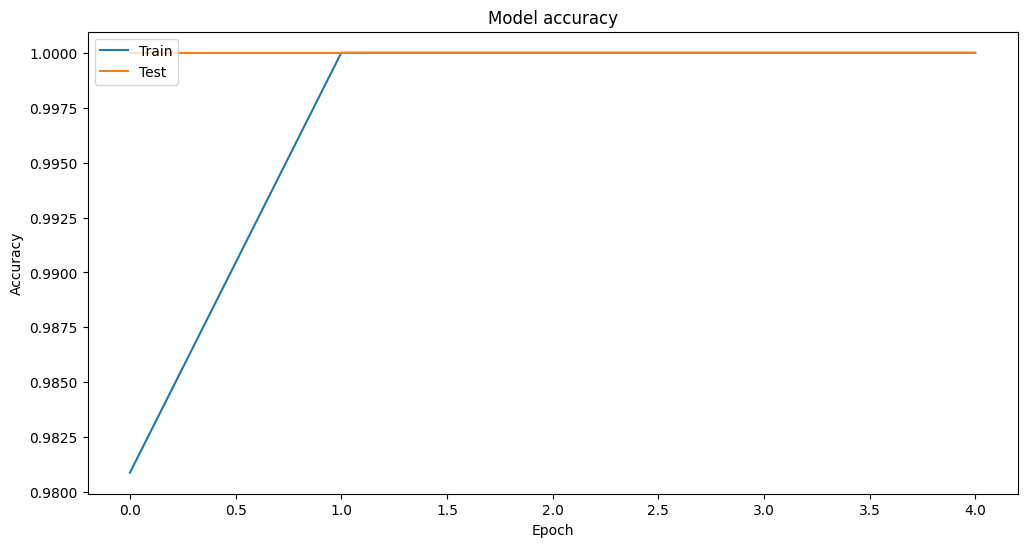

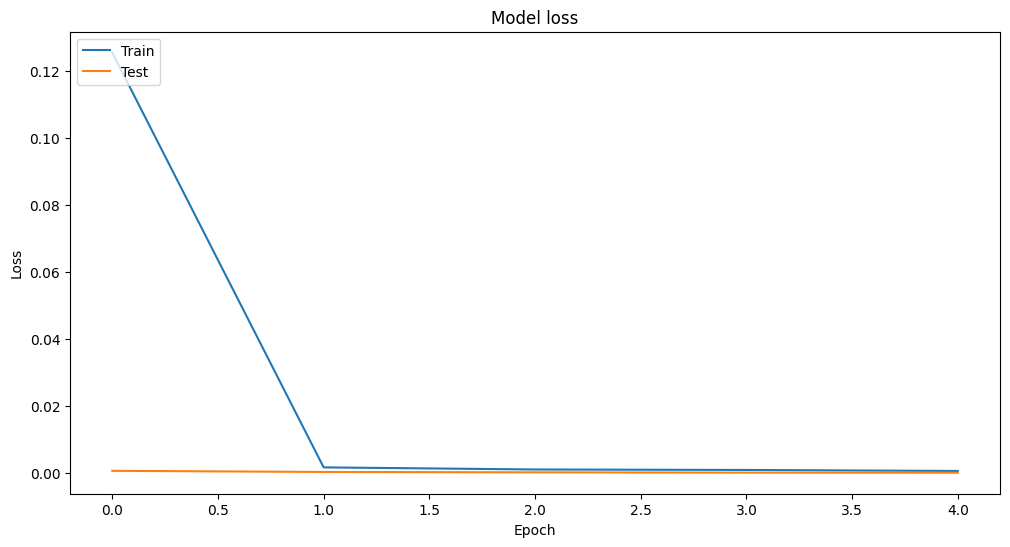

14/14 - 1s - loss: 1.3445e-04 - accuracy: 1.0000 - 1s/epoch - 84ms/step
Test Accuracy: 1.00


In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.2f}')


### Conclusion

This LSTM-based sentiment analysis of Intel product reviews provides valuable insights into customer perceptions and areas for improvement. By addressing the feedback, Intel can enhance customer satisfaction and product quality.
